# Volatility Arbitrage (arbitrage IV‑RV)

This notebook simulates a volatility arbitrage strategy that exploits the spread
between implied volatility (IV) and realized volatility (RV). A trajectory
of price is generated via a geometric Brownian motion, then a volatility
realized is calculated on a rolling horizon (30 days). One obtains a
implied volatility by adding random noise to the realized volatility,
what simulates the market gap. When \(	ext{IV} - 	ext{RV}\) exceeds a certain threshold,
the strategy sells variance (short position on volatility); when it is
negative below the threshold, she buys the variance (long position). The P&L
are calculated as the difference between implicit and realized variances.


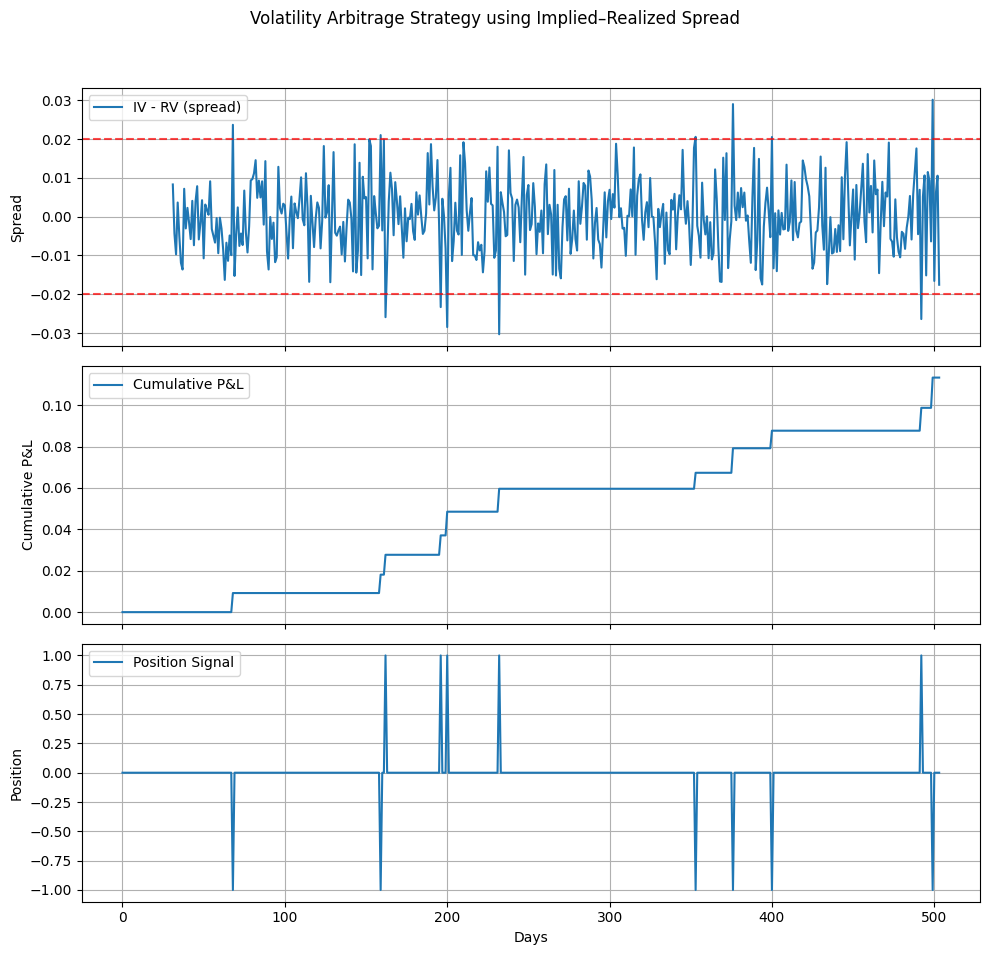

In [1]:
"""
Volatility Arbitrage Strategy using Implied–Realized Spread
==========================================================

We demonstrate a simple volatility arbitrage strategy based on the
spread between implied volatility (IV) and realized volatility (RV).  In
practice, volatility arbitrageurs observe that options markets often price
future volatility (implied vol) higher or lower than the volatility actually
realized by the underlying asset.  By taking positions that pay realized
variance and receive implied variance (or vice versa), one can attempt to
capture this discrepancy.  The strategy implemented here is pedagogical and
uses simulated price data rather than real market quotes.  It follows the
principles described in general volatility arbitrage literature: the goal is
to exploit mispricing between implied and realized volatility【725734690550063†L140-L178】.

Overview
--------

1. **Data generation** – We simulate a geometric Brownian motion (GBM) path
   for an underlying asset to obtain daily log returns.  This provides
   realized volatility over a rolling window.
2. **Implied volatility estimate** – For each day, we estimate an implied
   volatility as the realized volatility plus a random noise term.  This
   mimics the fact that implied vol may differ from historical vol due to
   market expectations or risk premia.  A positive noise implies IV > RV
   (options overpriced), a negative noise implies IV < RV (options
   underpriced).
3. **Volatility spread** – We compute the spread ``IV - RV``.  When the
   spread is sufficiently large, we enter a trade:
   - If ``spread > threshold`` we **sell** variance: we receive implied
     variance and pay realized variance (analogous to shorting a straddle or
     selling a variance swap).
   - If ``spread < -threshold`` we **buy** variance: we pay implied variance
     and receive realized variance (analogous to buying a straddle).
   - Otherwise, we stay flat.
4. **P&L calculation** – The payoff of a variance swap over a horizon ``H``
   days is proportional to ``realized_variance - implied_variance``.  We
   approximate the daily P&L of our position as:

   .. math::

      \text{P&L}_t \approx \alpha \times \left( \sigma^2_{\text{realized},t} - \sigma^2_{\text{implied},t} \right),

   where ``alpha`` is a notional scaling factor.  A short variance position
   yields P&L ``implied^2 - realized^2``, and a long variance position
   yields ``realized^2 - implied^2``.

This simple setup captures the essence of volatility arbitrage: exploit
systematic differences between market‑implied volatility and historically
observed volatility【725734690550063†L140-L178】.  The strategy can be extended to real data by
replacing the simulated path with historical returns and using actual
implied volatility (e.g., from option prices or the VIX index).

"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt


def simulate_gbm(
    S0: float,
    mu: float,
    sigma: float,
    dt: float,
    n_steps: int,
) -> np.ndarray:
    """Simulate a geometric Brownian motion path.

    Parameters
    ----------
    S0 : float
        Initial price.
    mu : float
        Drift (annualized).
    sigma : float
        Volatility (annualized).
    dt : float
        Time step (in years).
    n_steps : int
        Number of time steps.

    Returns
    -------
    np.ndarray
        Simulated price path of length ``n_steps + 1``.
    """
    t = np.linspace(0, n_steps * dt, n_steps + 1)
    # Generate Brownian increments
    dW = np.random.standard_normal(n_steps) * np.sqrt(dt)
    W = np.concatenate(([0.0], np.cumsum(dW)))
    X = (mu - 0.5 * sigma ** 2) * t + sigma * W
    S = S0 * np.exp(X)
    return S


def realized_vol(log_returns: np.ndarray, window: int) -> np.ndarray:
    """Compute rolling realized volatility (annualized) from log returns.

    Realized volatility for day ``t`` is computed from the previous
    ``window`` log returns.  The result is an array of the same length as
    ``log_returns`` with NaNs for indices less than ``window``.

    Parameters
    ----------
    log_returns : np.ndarray
        Array of log returns.
    window : int
        Number of observations used to compute the realized volatility.

    Returns
    -------
    np.ndarray
        Realized volatility (annualized) series.
    """
    rv = np.full_like(log_returns, np.nan, dtype=float)
    for i in range(window, len(log_returns)):
        window_returns = log_returns[i - window : i]
        rv[i] = np.sqrt(252) * np.std(window_returns, ddof=1)
    return rv


def implied_vol(realized_vol: float, noise_scale: float = 0.05) -> float:
    """Generate an implied volatility estimate given a realized volatility.

    We model the implied volatility as the realized volatility plus a random
    Gaussian noise term.  The ``noise_scale`` parameter controls the
    standard deviation of the noise relative to the volatility level.  If
    ``noise_scale`` is zero, the implied volatility equals the realized
    volatility.

    Parameters
    ----------
    realized_vol : float
        Realized volatility for a given date.
    noise_scale : float, optional
        Scale of the Gaussian noise added to realized volatility.  Defaults
        to 0.05 (i.e., 5% of the volatility level).

    Returns
    -------
    float
        Synthetic implied volatility.
    """
    noise = np.random.normal(loc=0.0, scale=noise_scale * realized_vol)
    iv = realized_vol + noise
    # Implied volatility should be positive
    return max(iv, 1e-6)


def variance_swap_pnl(implied_vol: float, realized_vol: float, notional: float = 1.0, position: str = "short") -> float:
    """Calculate the P&L of a variance swap position for one period.

    For a variance swap, the payoff is proportional to ``realized_variance -
    implied_variance``.  A **short** variance position receives the implied
    variance and pays the realized variance, yielding ``implied^2 -
    realized^2``; a **long** variance position yields ``realized^2 -
    implied^2``.

    Parameters
    ----------
    implied_vol : float
        Implied volatility for the period.
    realized_vol : float
        Realized volatility for the period.
    notional : float, optional
        Notional amount of the swap.  Defaults to 1.0.
    position : str, optional
        'short' or 'long'.  Defaults to 'short'.

    Returns
    -------
    float
        P&L of the variance swap for this period.
    """
    iv2 = implied_vol ** 2
    rv2 = realized_vol ** 2
    if position == "short":
        return notional * (iv2 - rv2)
    else:
        return notional * (rv2 - iv2)


def run_vol_arbitrage_strategy(
    log_returns: np.ndarray,
    window: int = 30,
    threshold: float = 0.02,
    noise_scale: float = 0.05,
    notional: float = 1.0,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Execute a volatility arbitrage strategy on a series of log returns.

    At each time step ``t`` greater than ``window``, compute the realized
    volatility over the previous ``window`` observations and generate an
    implied volatility estimate.  If the implied volatility minus realized
    volatility exceeds ``threshold``, enter a **short variance** trade.
    Conversely, if the spread is less than ``-threshold``, enter a **long
    variance** trade.  Otherwise, hold no position.  Compute the P&L for
    the period using ``variance_swap_pnl``.

    Parameters
    ----------
    log_returns : np.ndarray
        Log returns of the underlying.
    window : int, optional
        Rolling window length for realized volatility.  Defaults to 30.
    threshold : float, optional
        Threshold on ``IV - RV`` that triggers a trade.  Defaults to 0.02
        (i.e., 2 percentage points).
    noise_scale : float, optional
        Standard deviation of the noise added to realized vol to form IV.
    notional : float, optional
        Notional for the variance swap P&L calculation.  Defaults to 1.0.

    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray]
        Three arrays of length equal to ``len(log_returns)``:
        (spread, pnl, position), where ``position`` is +1 for long variance,
        -1 for short variance, and 0 for flat.
    """
    n = len(log_returns)
    spread = np.full(n, np.nan)
    pnl = np.zeros(n)
    position_signal = np.zeros(n)
    rv_series = realized_vol(log_returns, window)
    # Loop over periods starting after the window
    for i in range(window + 1, n):
        rv = rv_series[i]
        if np.isnan(rv):
            continue
        iv = implied_vol(rv, noise_scale)
        spread[i] = iv - rv
        if spread[i] > threshold:
            # Sell variance: short position
            pnl[i] = variance_swap_pnl(iv, rv, notional, position="short")
            position_signal[i] = -1
        elif spread[i] < -threshold:
            # Buy variance: long position
            pnl[i] = variance_swap_pnl(iv, rv, notional, position="long")
            position_signal[i] = +1
        else:
            pnl[i] = 0.0
            position_signal[i] = 0
    return spread, pnl, position_signal


def demo() -> None:
    """Run a demonstration of the implied–realized spread strategy on simulated data."""
    # Simulate a price path
    S0 = 100.0
    mu = 0.05  # annual drift
    sigma = 0.20  # annual volatility
    n_days = 252 * 2  # two years of daily data
    dt = 1 / 252
    prices = simulate_gbm(S0, mu, sigma, dt, n_days)
    log_returns = np.diff(np.log(prices))

    # Run strategy
    window = 30
    threshold = 0.02  # 2% vol difference
    spread, pnl, pos = run_vol_arbitrage_strategy(
        log_returns, window=window, threshold=threshold, noise_scale=0.05, notional=1.0
    )
    # Compute cumulative P&L ignoring NaNs
    cum_pnl = np.nancumsum(pnl)

    # Plot results
    days = np.arange(len(spread))
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    axs[0].plot(days, spread, label="IV - RV (spread)")
    axs[0].axhline(threshold, color="r", linestyle="--", alpha=0.7)
    axs[0].axhline(-threshold, color="r", linestyle="--", alpha=0.7)
    axs[0].set_ylabel("Spread")
    axs[0].legend()
    axs[0].grid(True)
    axs[1].plot(days, cum_pnl, label="Cumulative P&L")
    axs[1].set_ylabel("Cumulative P&L")
    axs[1].legend()
    axs[1].grid(True)
    axs[2].plot(days, pos, label="Position Signal")
    axs[2].set_ylabel("Position")
    axs[2].set_xlabel("Days")
    axs[2].legend()
    axs[2].grid(True)
    plt.suptitle("Volatility Arbitrage Strategy using Implied–Realized Spread")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


if __name__ == "__main__":
    demo()